In [1]:
# imports
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from sklearn import preprocessing

In [2]:
# going to use tsla
fn ='./proj_data_TSLA.csv'

In [3]:
# just loading the data here, if you want to see how it is gathered / graphs check Proj_pull_data 
df = pd.read_csv(fn, index_col=0)
df.shape

(26276, 6)

In [4]:
# data is minute data for about 46 days minus after hours
df.head()

,open,high,low,close,volume,datetime
0,843.45,846.00,843.45,844.94,2431,2021-10-18 08:00:00
1,845.00,845.00,844.15,844.44,303,2021-10-18 08:01:00
2,846.00,846.00,846.00,846.00,300,2021-10-18 08:02:00
3,845.11,845.11,844.99,844.99,400,2021-10-18 08:03:00
4,845.61,845.61,845.00,845.00,918,2021-10-18 08:05:00


In [5]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

### Creating Target Labels  
The main idea is to calculate the percent change from the last high to the current high, this will be a percentage between -100 and 100. From there classify by the percent change as outlined below. After looking at the data there are very few values outside the range of -.5 to .5 

The y is calculated as the percent change:  
$$
  Y=\frac{(X_n-X_{n+1})}{X_n}*100
$$
From there the percent change is divided into 10 classes from -1 to 1 being:  
[-100  -80  -60  -40  -20 0 20 40 60 80  100]  
which correspond to class  
[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]

In [6]:
# scaler fits data to between 0 and 1 
# todo can we normalize all test/train or need to separate?
dfn = normalize_data(df)

# now lets turn this into a dataset with a window of data and a forecast target
# so the y value will be the 'next' minute's high value
# we calculate the %change between the 'next' high and the 'last' high
# y = (X - X
# NOTE !! a lot of manual tuning went in here to find a good way to scale data so there are a reasonable number of classes that are close to same size ! 
dfn['y'] = (((dfn['high']-dfn['high'].shift(1))/dfn['high'])*100).clip(-1,1)
# force everything to this interval 
dfn['y'] = (dfn['y']//.5)*.5
# we will clip our values at between -20 and +20 because there are very very few values outside that range
# note that is just for this dataset, for hour candles it would be much different
dfn['y'] = dfn['y'].round(2)
# we will also get rid of the other columns and clean up nans
df2 = dfn[['open','high','low','close','y']]
# there will be a na for the first row only
df2 = df2.replace([np.inf, -np.inf], np.nan)
df2 = df2.dropna()
# integers become the classes

#df2['y'] = df2['y'].astype(int)
df2.head()

,open,high,low,close,y
1,0.003845,0.000000,0.007986,0.000000,-1.0
2,0.006326,0.002469,0.012564,0.003886,1.0
3,0.004118,0.000272,0.010065,0.001370,-1.0
4,0.005358,0.001506,0.010090,0.001395,1.0
5,0.006276,0.002469,0.010090,0.001395,1.0


In [7]:
# let's clean up our classes, instead of -5,5 0,10
# new column 'yc' is Y Class
df2['yc'] = df2['y']
vc = df2['y'].value_counts(sort=False).sort_index(ascending=True)
print(vc)
keys = vc.keys()
print(keys)
df2['yc'].replace(keys, range(0,len(keys)), inplace=True)
df2['yc'] = df2['yc'].astype(int)
df2['yc'].value_counts().sort_index()

-1.0    3997
-0.5    9278
 0.0    8971
 0.5    2099
 1.0    1930
Name: y, dtype: int64
Float64Index([-1.0, -0.5, 0.0, 0.5, 1.0], dtype='float64')


0    3997
1    9278
2    8971
3    2099
4    1930
Name: yc, dtype: int64

### Understanding the class labels  
Let's take a second to talk about the labels. Please note the labels have changed since I wrote this, this is just an example.   
-0.24    2041  = 0 -> large negative  
-0.16    2651  = 1 -> medium negative  
-0.08    7787  = 2 -> small negative  
 0.00    9102  = 3 -> small positive  
 0.08    2136  = 4 -> medium positive  
 0.16    2550  = 5 -> large positive  
 After much tweaking I was able to get 6 classes with a reasonable distrubution across all of them. So this way we don't have a horrible unbalanced dataset. So all of the values at 0.00 (9102) are between 0.0 and 0.08 which from a trading perspective would mean a very small amount of profit if you are long. Likewise for the 7787 values between 0.0 and -.08 except those values would be a small loss. We could further break it down into just two classes 'going up' or 'going down' but I think there is value in classifying as is meaning basically (from a long perspective) [big loss, medum loss, small loss, small gain, medium gain, big gain] which seems realistic.  
From there we don't want long float numbers as 'classes' so we replace them with a simple integer number, we can refer back to this to understand what the classes are.

In [8]:
Xw = []
Yw = []
w=[]
for i,r in df2.iterrows():
    if i<21:
        # add the first to the window
        w.append(r[['open','high','low','close']].values)
    else:
        # append the other rows to the window [:20]
        w.append(r[['open','high','low','close']].values)
        w = w[1:] # pop off  the first entry
        Xw.append(np.array(w))
        # we will need to shift this later !!
        Yw.append(r['yc'])
    # for testing, break early
    #if i > 100:
    #    break
        
#push into numpy array
Xw = np.array(Xw)
Yw = np.array(Yw)
# Shift Y it should be the answer for the 'next
# just copy the first value and push into start, will shift all to the right
# that's wrong it would make it more latent, not less
#Yw = np.insert(Yw,0,Yw[0])
# need to pop the first value instead
Yw = Yw[2:]

# strip off the X that have no y, since we only have y for the next we lose the first ones
Xw = Xw[:Yw.shape[0]]

In [9]:
Xw.shape

(26253, 20, 4)

In [10]:
Yw.shape

(26253,)

In [13]:
# just glance at our y 'windowed' values
list(Yw[0:10])

[2.0, 4.0, 0.0, 0.0, 4.0, 0.0, 4.0, 0.0, 4.0, 4.0]

In [16]:
# Convert to integers because that's what's expected for the sparce categorical
Yw = Yw.astype(np.int32)
list(Yw[0:10])

[2, 4, 0, 0, 4, 0, 4, 0, 4, 4]

In [17]:
print('X Windowed Shape:',Xw.shape,' Y Windowed Shape:',Yw.shape)

X Windowed Shape: (26253, 20, 4)  Y Windowed Shape: (26253,)


In [18]:
#X_train ,X_test, y_train, y_test = train_test_split(Xw,tf.keras.utils.to_categorical(Yw), test_size=.25)
X_train ,X_test, y_train, y_test = train_test_split(Xw,Yw, test_size=.25)
print('Shapes:',X_train.shape ,X_test.shape, y_train.shape, y_test.shape)

Shapes: (19689, 20, 4) (6564, 20, 4) (19689,) (6564,)


In [19]:
def build_model(layers): # build a LSTM model
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d)) # with probability of 0.3
        
    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d)) # with probability of 0.3
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))  
          
    model.add(Dense(layers[2],activation='relu'))
    
    # at 0.0001 acc max at 38%
    # at 0.001 ?
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001,
                                       beta_1=0.9,
                                       beta_2=0.999,
                                       epsilon=1e-07,
                                       amsgrad=False,
                                       name='Adam'
                                       ),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [20]:
model = build_model([4,20,Yw.max()+1])
model.summary()
hist = model.fit(X_train,y_train,validation_split=.2,batch_size=64,epochs=20,steps_per_epoch=200)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 64)            17664     
_________________________________________________________________
dropout (Dropout)            (None, 20, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 52,933
Trainable params: 52,933
Non-trainable params: 0
____________________________________________________

In [16]:
model.evaluate(X_test,y_test)

206/206 [==============================] - 12s 57ms/step - loss: 1.3524 - accuracy: 0.3844 ETA: 0s - loss: 1.3530 - accura


[1.3524144887924194, 0.38436928391456604]

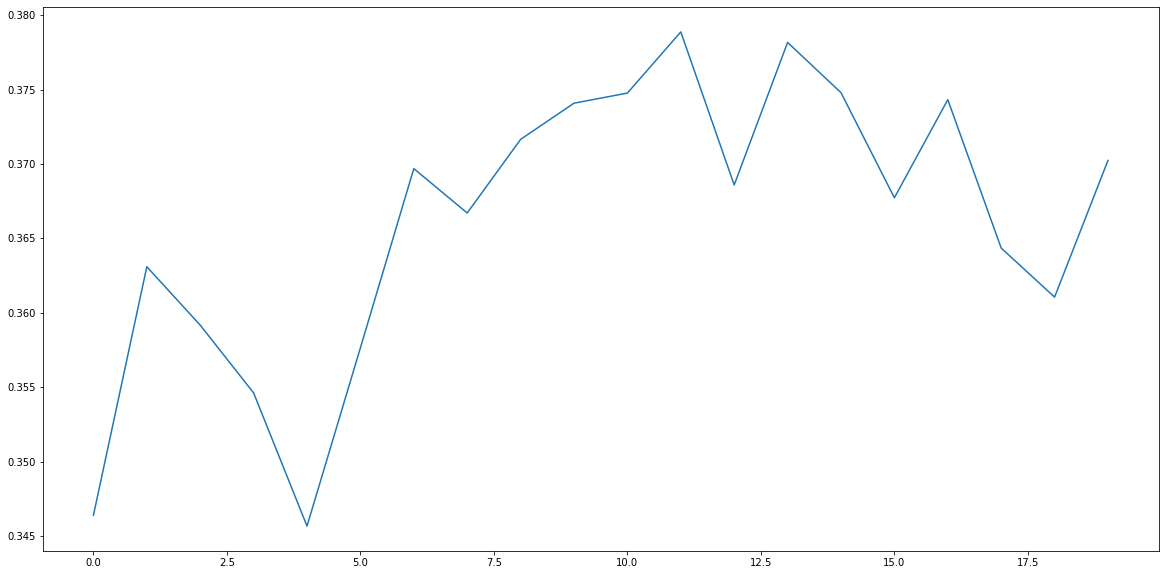

In [17]:
# plot the loss, note since this is a time series problem accuracy does not make much sense
#plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.show()

### Save Point

In [20]:
# save off all data, so we can start again from here instead of redoing all above
np.save('Xw.np',Xw)
np.save('Yw.np',Yw)
model.save('lstm_forecaster.h5')


### Conclusion  
It is clear to see that this model fails to achive any decent results. Not only because the accuracy is so low, but also because there was little to no improvement from the starting accuracy. In other words improving from 35% accuracy to 37% accuracy is worse than improving from 5% to 25%, it shows there is no real improvement.  